In [2]:
import re
import pandas as pd
import pymongo
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

In [3]:
stopwords = nltk.corpus.stopwords.words('english')
stop_words= set(stopwords)

In [4]:
# Load data

df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df['sentiment']=np.where(df['sentiment'].str.contains("negative"),0,1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [6]:
df['sentiment'].value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

In [7]:
# Check for missing values

df.isna().sum()

review       0
sentiment    0
dtype: int64

In [8]:
df = df.dropna()
df.shape

(50000, 2)

In [9]:
 
####  You can normalize the text by converting it to lowercase, removing special characters, 
#      and potentially removing stop words 


import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def remove_stopwords(text):
    stop_words = stopwords.words('english')
    words = text.split()
    filtered_sentence = ''
    for word in words:
        if word not in stop_words:
            filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence


def normalize_text(text):
    text = text.lower()
    # get rid of urls
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # get rid of non words and extra spaces
    text = re.sub('\\W', ' ', text)
    text = re.sub('\n', '', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('^ ', '', text)
    text = re.sub(' $', '', text)
    return text



def remove_punctuation(text):
    table = str.maketrans('','',string.punctuation)
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = word.translate(table)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence


def stemming(text):
    ps = PorterStemmer()
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = ps.stem(word)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence


def clean_text(text):
    text = text.lower()
    text = text.replace(',',' , ')
    text = text.replace('.',' . ')
    text = text.replace('/',' / ')
    text = text.replace('@',' @ ')
    text = text.replace('#',' # ')
    text = text.replace('?',' ? ')
    text = normalize_text(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = stemming(text)
    return text

<>:23: SyntaxWarning: invalid escape sequence '\S'
<>:23: SyntaxWarning: invalid escape sequence '\S'
/var/folders/v_/8bq_mt2x79qcll80qb48560w0000gn/T/ipykernel_32555/4016547438.py:23: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('https?://\S+|www\.\S+', '', text)


In [10]:
# Apply cleaning to the dataset

df['cleaned_review']= df['review'].apply(clean_text)

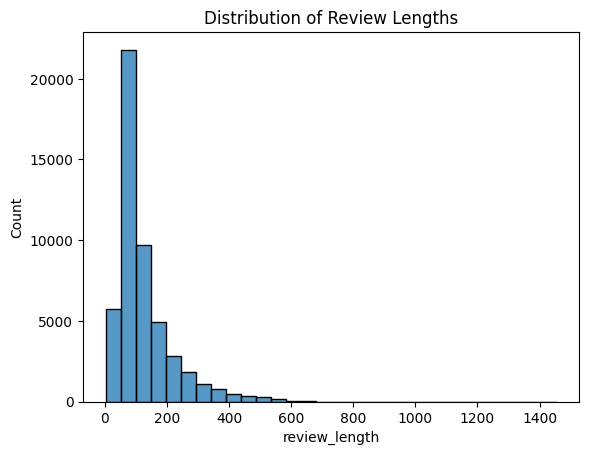

In [11]:
# Analyze word/sentence lengths

df['review_length'] = df['cleaned_review'].apply(lambda x: len(x.split()))
sns.histplot(df['review_length'], bins=30)
plt.title("Distribution of Review Lengths")
plt.show()

In [12]:
####  Store Data in MongoDB

from pymongo import MongoClient

# Connect to MongoDB server
client = MongoClient('mongodb://localhost:27017/')

#connect to a database
db = client['imdb_reviews']

# Create a collection 
collection = db['processed_reviews']

# Insert the cleaned_review and review_length data into the collection
records = df[['review', 'cleaned_review', 'sentiment', 'review_length']].to_dict('records')
collection.insert_many(records)


InsertManyResult([ObjectId('6707c53018335cf755f43e1c'), ObjectId('6707c53018335cf755f43e1d'), ObjectId('6707c53018335cf755f43e1e'), ObjectId('6707c53018335cf755f43e1f'), ObjectId('6707c53018335cf755f43e20'), ObjectId('6707c53018335cf755f43e21'), ObjectId('6707c53018335cf755f43e22'), ObjectId('6707c53018335cf755f43e23'), ObjectId('6707c53018335cf755f43e24'), ObjectId('6707c53018335cf755f43e25'), ObjectId('6707c53018335cf755f43e26'), ObjectId('6707c53018335cf755f43e27'), ObjectId('6707c53018335cf755f43e28'), ObjectId('6707c53018335cf755f43e29'), ObjectId('6707c53018335cf755f43e2a'), ObjectId('6707c53018335cf755f43e2b'), ObjectId('6707c53018335cf755f43e2c'), ObjectId('6707c53018335cf755f43e2d'), ObjectId('6707c53018335cf755f43e2e'), ObjectId('6707c53018335cf755f43e2f'), ObjectId('6707c53018335cf755f43e30'), ObjectId('6707c53018335cf755f43e31'), ObjectId('6707c53018335cf755f43e32'), ObjectId('6707c53018335cf755f43e33'), ObjectId('6707c53018335cf755f43e34'), ObjectId('6707c53018335cf755f43e

In [13]:
collection.create_index([("sentiment", pymongo.ASCENDING)])


'sentiment_1'

In [14]:
df = pd.DataFrame(list(collection.find()))
df

,_id,review,cleaned_review,sentiment,review_length
0,6707c53018335cf755f43e1c,One of the other reviewers has mentioned that ...,one review mention watch 1 oz episod hook righ...,1,169
1,6707c53018335cf755f43e1d,A wonderful little production. <br /><br />The...,wonder littl product br br film techniqu unass...,1,92
2,6707c53018335cf755f43e1e,I thought this was a wonderful way to spend ti...,thought wonder way spend time hot summer weeke...,1,89
3,6707c53018335cf755f43e1f,Basically there's a family where a little boy ...,basic famili littl boy jake think zombi closet...,0,72
4,6707c53018335cf755f43e20,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love time money visual stun film...,1,133
...,...,...,...,...,...
49995,6707c53018335cf755f50167,I thought this movie did a down right good job...,thought movi right good job creativ origin fir...,1,84
49996,6707c53018335cf755f50168,"Bad plot, bad dialogue, bad acting, idiotic di...",bad plot bad dialogu bad act idiot direct anno...,0,61
49997,6707c53018335cf755f50169,I am a Catholic taught in parochial elementary...,cathol taught parochi elementari school nun ta...,0,117
49998,6707c53018335cf755f5016a,I'm going to have to disagree with the previou...,go disagre previou comment side maltin one sec...,0,113


In [15]:
### Text Classification with BERT

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification



/Users/manavbaisoya/Desktop/assignment_Case/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-10 17:45:02.898881: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
### # Load BERT pre-trained model for sequence classification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
df['review']= df['cleaned_review']
df = df[0:10]


X=list(df['review'])
y=list(df['sentiment'])


In [18]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)


# Check the number of records in training and testing dataset.
print(f'The training dataset has {len(X_train)} records.')
print(f'The testing dataset has {len(X_test)} records.')

The training dataset has 8 records.
The testing dataset has 2 records.


In [19]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [20]:

train_dataset = Dataset(X_train_tokenized, y_train)
test_dataset = Dataset(X_test_tokenized, y_test)

In [21]:
# Define compute metrics function
def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [22]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    num_train_epochs=1,
    per_device_train_batch_size=8

)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [23]:
# Fine-tune

trainer.train()

100%|██████████| 1/1 [00:32<00:00, 32.69s/it]

{'train_runtime': 32.7455, 'train_samples_per_second': 0.244, 'train_steps_per_second': 0.031, 'train_loss': 0.6696087121963501, 'epoch': 1.0}


TrainOutput(global_step=1, training_loss=0.6696087121963501, metrics={'train_runtime': 32.7455, 'train_samples_per_second': 0.244, 'train_steps_per_second': 0.031, 'total_flos': 924999804000.0, 'train_loss': 0.6696087121963501, 'epoch': 1.0})

In [24]:
# Evaluate the model

trainer.evaluate()

100%|██████████| 1/1 [00:00<00:00, 16.32it/s]

<class 'transformers.trainer_utils.EvalPrediction'>


{'eval_loss': 0.7192398309707642,
 'eval_accuracy': 0.5,
 'eval_precision': 0.5,
 'eval_recall': 1.0,
 'eval_f1': 0.6666666666666666,
 'eval_runtime': 0.711,
 'eval_samples_per_second': 2.813,
 'eval_steps_per_second': 1.407,
 'epoch': 1.0}

In [25]:
import pickle

filename = 'classification.pkl'
pickle.dump(model, open(filename, 'wb'))

In [26]:
####   Text Generation with GPT-2

import tensorflow as tf
import warnings
from transformers import GPT2LMHeadModel, GPT2Tokenizer, pipeline


In [27]:
def generate_text(prompt):
    generator = pipeline('text-generation', model='gpt2')
    generated_text = generator(prompt, max_length=400, num_return_sequences=1, truncation=True)

    print(generated_text[0]['generated_text'])

In [28]:
import pickle
filename = 'generation.pkl'
pickle.dump(generate_text, open(filename, 'wb'))

In [ ]:
#####   [IMDB Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)